In [34]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [23]:
df = pd.read_csv(r'dataset.csv')
df.drop([0],axis=0,inplace=True)
df.head(3)

,Materials,Place,Condition,C,Si,Mn,P,S,Cu,Cr,...,Air Temperature,Relative humidity,Cl deposition rate,SO2 deposition rate,Precipitation,Velocity of Wind,TOW,Solar,Years,Corrosion
1,Fe¹,Tsukuba,open,0.001,<0.003,<0.01,0.0008,0.0011,<0.01,<0.01,...,14.6,NaN,3.4,4.8,1167.0,2.5,NaN,NaN,1.0,355.35
2,Fe¹,Tsukuba,open,0.001,<0.003,<0.01,0.0008,0.0011,<0.01,<0.01,...,16.3,75.0,3.1,5.8,726.5,2.0,4196.2,5561.04,2.0,529.65
3,Fe¹,Tsukuba,open,0.001,<0.003,<0.01,0.0008,0.0011,<0.01,<0.01,...,15.8,80.0,3.4,5.4,997.0,1.5,5143.8,5920.18,3.0,706.65


In [24]:
df.columns

Index(['Materials', 'Place', 'Condition', 'C', 'Si', 'Mn', 'P', 'S', 'Cu',
       'Cr', 'Ni', 'Al', 'Ti', 'V', 'Air Temperature', 'Relative humidity',
       'Cl deposition rate', 'SO2 deposition rate', 'Precipitation',
       'Velocity of Wind', 'TOW', 'Solar', 'Years', 'Corrosion'],
      dtype='object')

#  Preprocessing

### String to numeric

In [25]:
df['Si'] = df['Si'].replace("<0.003",0.003)
df['Mn'] = df['Mn'].replace("<0.01",0.01)
df['Cu'] = df['Cu'].replace("<0.01",0.01)
df['Cr'] = df['Cr'].replace("<0.01",0.01)
df['Ni'] = df['Ni'].replace("<0.01",0.01)
df['Al'] = df['Al'].replace("<0.01",0.01)
df['Ti'] = df['Ti'].replace("<0.01",0.01)
df['V'] = df['V'].replace("<0.01",0.01)

In [26]:
for data in df["Corrosion"]:
    if type(data)==str and data[0]==">":
        df["Corrosion"]=df["Corrosion"].replace(data,float(data[1:]))

In [27]:
for i in col:
    df[i] = pd.to_numeric(df[i])

### Splitting as train and test

In [28]:
X = df.iloc[:,df.columns!='Corrosion'].values
y = pd.DataFrame(df.iloc[:,-1].values)

### Encoding

In [29]:
le=LabelEncoder()
X[:,0]=le.fit_transform(X[:,0])
X[:,1]=le.fit_transform(X[:,1])
X[:,2]=le.fit_transform(X[:,2])

### Handling Missing values

In [30]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(X)
X = imputer.transform(X)

### Scaler

In [21]:
scaler = StandardScaler()
y.fillna(value=y.mean(), inplace=True)
y=y.values.ravel()
y_scaled=scaler.fit_transform(y.reshape(-1,1))
y_scaled=y_scaled.ravel()

## Fitting models

In [37]:
regressor = [["RFR",RandomForestRegressor(n_estimators=100,random_state=0)],["SVR",SVR(kernel='rbf',gamma='auto',cache_size=500)],["MLR",LinearRegression(n_jobs=100,normalize=False)],["Hybrid Model"]]
ans = []
predictions={"RFR":[],"MLR":[],"SVR":[]}
for i in range(len(regressor)-1):
    temp=[]
    for j in range(50,100,10):
        X_train,X_test,y_train,y_test = train_test_split(X,y_scaled,test_size=(100-j)/100,random_state=0)
        
        regressor[i][1].fit(X_train,y_train)
        y_pred = regressor[i][1].predict(X_test)
        predictions[regressor[i][0]].append(y_pred)
        acc = r2_score(y_test,y_pred)
        
        #acc = cross_val_score(regressor[i][1],X_train,y_train,cv=10)
        temp.append(np.mean(acc))
    ans.append(temp)

### Hybrid Model

In [38]:
temp=[] 
for j in range(50,100,10):
    X_train,X_test,y_train,y_test = train_test_split(X,y_scaled,test_size=(100-j)/100,random_state=0)
    y_pred= (0.92*predictions["RFR"][j//10-5]+0.05*predictions["MLR"][j//10-5]+0.36*predictions["SVR"][j//10-5])
    acc=r2_score(y_test,y_pred)
    temp.append(np.mean(acc))  
ans.append(temp)

## Sample plots

In [40]:
colour = ['blue','green','red','black']

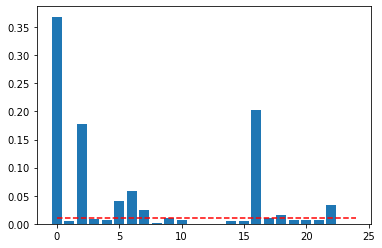

In [41]:
importance=regressor[0][1].feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.hlines(0.01,- 0, 24, color='red',linestyle='--')
plt.show()

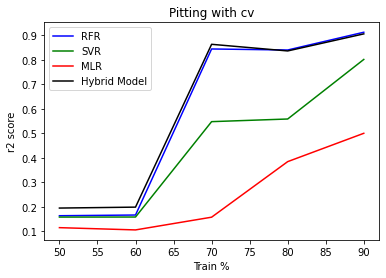

In [42]:
train = np.arange(50,100,10)
for i in range(4):
    plt.plot(train,ans[i],color=colour[i],label=regressor[i][0])

plt.title("Pitting with cv")
plt.xlabel("Train %")
plt.ylabel("r2 score")
plt.legend()
plt.show()